In [20]:
train = read.csv(file = '../input/457-engineered/train_engineered (2).csv', header = TRUE)
test = read.csv(file = '../input/457-engineered/test_engineered (2).csv', header = TRUE)
train_sub = train[train$Sales > 0, ]#only use positive Sales in training data
testOpen = (test$Open == 1)
test_sub = test[testOpen, ] #only needs to do prediction for open days
colnames(train_sub)

[1] "Store"               "DayOfWeek"           "Sales"              
 [4] "Customers"           "Open"                "Promo"              
 [7] "SchoolHoliday"       "year"                "month"              
[10] "day"                 "StoreType"           "CompetitionDistance"

from feature selection, our current models and feature selected are:

Customer:

lm(formula = Customers ~ factor(Store) + factor(DayOfWeek) + Promo + SchoolHoliday + factor(year) + factor(month) + day + factor(Store):factor(DayOfWeek) + factor(Store):Promo + factor(Store):SchoolHoliday + factor(Store):factor(year) + factor(Store):factor(month) + factor(Store):day + factor(DayOfWeek):SchoolHoliday + factor(DayOfWeek):factor(year) + factor(DayOfWeek):factor(month) + factor(DayOfWeek):day + Promo:factor(year) + Promo:factor(month) + Promo:day + SchoolHoliday:factor(month) + SchoolHoliday:day + factor(month):day + CompetitionDistance + StoreType, data = train_sub)

Sales:

lm(formula = Sales ~ factor(Store) + factor(DayOfWeek) + Customers + Promo + SchoolHoliday + factor(year) + factor(month) + day + factor(Store):factor(DayOfWeek) + factor(Store):Customers + factor(Store):Promo + factor(Store):SchoolHoliday + factor(Store):factor(year) + factor(Store):factor(month) + factor(Store):day + factor(DayOfWeek):Customers + factor(DayOfWeek):Promo + factor(DayOfWeek):SchoolHoliday + factor(DayOfWeek):factor(year) + factor(DayOfWeek):factor(month) + Customers:Promo + Customers:SchoolHoliday + Customers:factor(year) + Customers:factor(month) + Customers:day + Promo:SchoolHoliday + Promo:factor(year) + Promo:factor(month) + Promo:day + SchoolHoliday:factor(year) + SchoolHoliday:factor(month) + factor(year):factor(month) + factor(year):day + factor(month):day + CompetitionDistance, data = train_sub)

# ridge regression for sales

In [21]:
library(caret)
dummies <- dummyVars(formula = Sales ~ factor(Store) + factor(DayOfWeek) + Customers + Promo + SchoolHoliday + factor(year) + factor(month) + day + factor(Store):factor(DayOfWeek) + factor(Store):Customers + factor(Store):Promo + factor(Store):SchoolHoliday + factor(Store):factor(year) + factor(Store):factor(month) + factor(Store):day + factor(DayOfWeek):Customers + factor(DayOfWeek):Promo + factor(DayOfWeek):SchoolHoliday + factor(DayOfWeek):factor(year) + factor(DayOfWeek):factor(month) + Customers:Promo + Customers:SchoolHoliday + Customers:factor(year) + Customers:factor(month) + Customers:day + Promo:SchoolHoliday + Promo:factor(year) + Promo:factor(month) + Promo:day + SchoolHoliday:factor(year) + SchoolHoliday:factor(month) + factor(year):factor(month) + factor(year):day + factor(month):day + CompetitionDistance, data = train_sub)
train_dummies = predict(dummies, newdata = train_sub)
dim(train_dummies)


[1] 14515   755

In [22]:
library(glmnet)
x = as.matrix(train_dummies)
y_train = train_sub$Sales
myridge = glmnet(x, y_train, family = 'gaussian',alpha = 0)


Loading required package: Matrix

Loaded glmnet 3.0-2




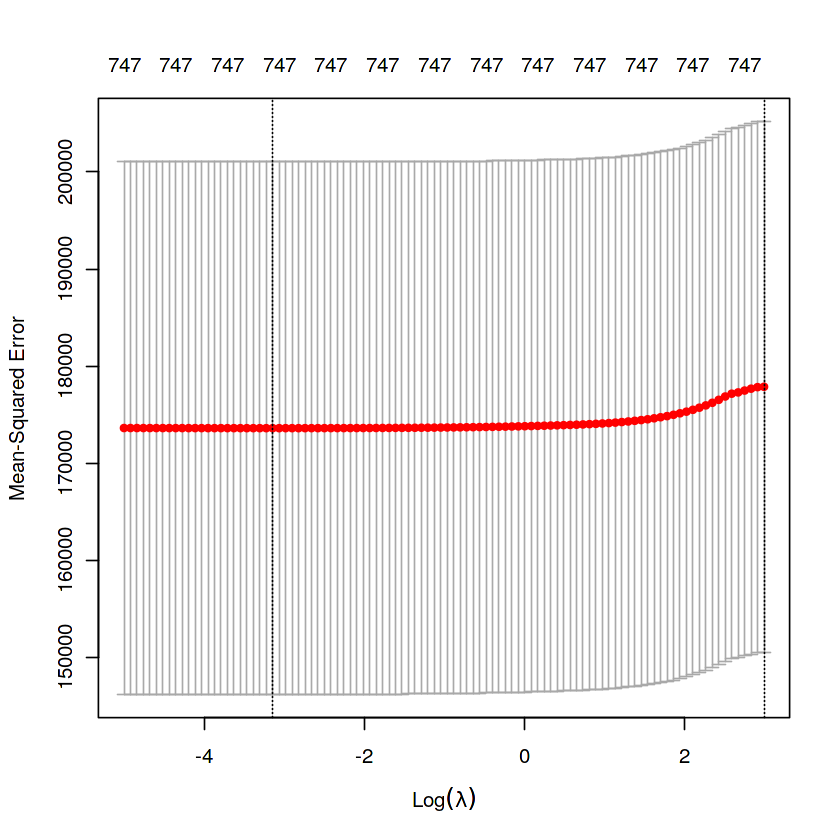

In [23]:
lam.seq = exp(seq(-5, 3, length=100))
ridge.cv.out = cv.glmnet(x,y_train, family = 'gaussian', alpha = 0, lambda = lam.seq) 
plot(ridge.cv.out)

In [24]:
# smallest cv error
ridge.cv.out$lambda.min

[1] 0.04322163

In [25]:
# one-standard deviation rule
ridge.cv.out$lambda.1se

[1] 20.08554

# TEST RMSPE

In [37]:
library(MLmetrics)
# self test RMSPE
smp_size <- floor(0.75 * nrow(train_sub))

## set the seed to make your partition reproducible
set.seed(123)
train_ind <- sample(seq_len(nrow(train_sub)), size = smp_size)

train_1 <- train_sub[train_ind, ]
train_1dummy <-as.matrix(predict(dummies, newdata = train_1))
test_1 <- train_sub[-train_ind, ]
test_1dummy <-as.matrix(predict(dummies, newdata = test_1))

# lambda = ridge.cv.out$lambda.min 0.0696126264688813
# lambda = ridge.cv.out$lambda.1se 0.0699129321153788
ridge.mod <- glmnet(train_1dummy, train_1$Sales, family = 'gaussian',alpha = 0, lambda = ridge.cv.out$lambda.min)
y_pred = predict(ridge.mod, test_1dummy)
y_true = as.numeric(as.vector(unlist(test_1['Sales'])))

RMSPE(y_pred = y_pred, y_true = y_true)

[1] 0.06991293

lambda.min a little bit better

# ridge regression for Customer

In [50]:
customer_dum <- dummyVars(formula = Customers ~ factor(Store) + factor(DayOfWeek) + Promo + SchoolHoliday + factor(year) + factor(month) + day + factor(Store):factor(DayOfWeek) + factor(Store):Promo + factor(Store):SchoolHoliday + factor(Store):factor(year) + factor(Store):factor(month) + factor(Store):day + factor(DayOfWeek):SchoolHoliday + factor(DayOfWeek):factor(year) + factor(DayOfWeek):factor(month) + factor(DayOfWeek):day + Promo:factor(year) + Promo:factor(month) + Promo:day + SchoolHoliday:factor(month) + SchoolHoliday:day + factor(month):day + CompetitionDistance + StoreType, data = train_sub)

train_c_dum = predict(customer_dum, newdata = train_sub)
dim(train_c_dum)

[1] 14515   669

In [51]:
x_c = as.matrix(train_c_dum)
y_c_train = train_sub$Customers
myridge = glmnet(x_c, y_c_train, family = 'gaussian',alpha = 0)

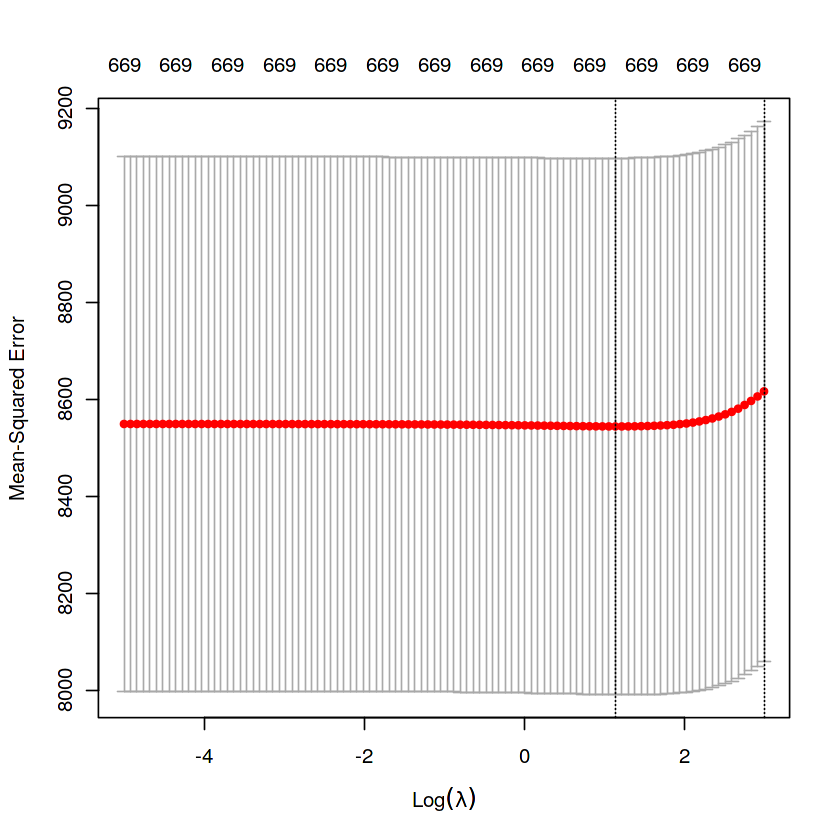

In [52]:
lam.seq = exp(seq(-5, 3, length=100))
ridge.cv.out = cv.glmnet(x_c,y_c_train, family = 'gaussian', alpha = 0, lambda = lam.seq) 
plot(ridge.cv.out)

In [53]:
# smallest cv error
ridge.cv.out$lambda.min

[1] 3.131193

In [55]:
# one-standard deviation rule
ridge.cv.out$lambda.1se

[1] 20.08554

In [56]:
library(MLmetrics)
# self test RMSPE
smp_size <- floor(0.75 * nrow(train_sub))

## set the seed to make your partition reproducible
set.seed(123)
train_ind <- sample(seq_len(nrow(train_sub)), size = smp_size)

train_1 <- train_sub[train_ind, ]
train_1dummy <-as.matrix(predict(customer_dum, newdata = train_1))
test_1 <- train_sub[-train_ind, ]
test_1dummy <-as.matrix(predict(customer_dum, newdata = test_1))

# lambda = ridge.cv.out$lambda.min 0.148385416053673
# lambda = ridge.cv.out$lambda.1se 0.151375357893329
ridge.mod <- glmnet(train_1dummy, train_1$Customers, family = 'gaussian',alpha = 0, lambda = ridge.cv.out$lambda.min)
y_pred = predict(ridge.mod, test_1dummy)
y_true = as.numeric(as.vector(unlist(test_1['Customers'])))

RMSPE(y_pred = y_pred, y_true = y_true)

[1] 0.1483854

Actually customer one is worse than linear regression, but sales one is better.